# Parte 3: O Coração do Projeto - Modelagem e Avaliação Comparativa

## Projeto: Previsão de Churn de Clientes de Telecomunicações

**Objetivo:** Treinar, comparar e avaliar criticamente diferentes modelos de Machine Learning para prever churn de clientes.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Validação cruzada
from sklearn.model_selection import cross_val_score

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## Carregamento dos Dados Processados

Vamos carregar os dados que foram preparados no notebook anterior.

In [2]:
# Carregar dados processados
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("="*70)
print("DADOS CARREGADOS COM SUCESSO")
print("="*70)
print(f"\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nDistribuição de classes no treino: {np.bincount(y_train)}")
print(f"Distribuição de classes no teste: {np.bincount(y_test)}")

DADOS CARREGADOS COM SUCESSO

X_train: (5625, 30)
X_test: (1407, 30)
y_train: (5625,)
y_test: (1407,)

Distribuição de classes no treino: [4130 1495]
Distribuição de classes no teste: [1033  374]


## 3.1. Treinamento de Múltiplos Modelos

Vamos treinar **6 algoritmos diferentes** apropriados para classificação:

1. **Regressão Logística** - Modelo linear baseline
2. **Árvore de Decisão** - Modelo interpretável baseado em regras
3. **Random Forest** - Ensemble de árvores (bagging)
4. **Gradient Boosting** - Ensemble sequencial (boosting)
5. **SVM (Support Vector Machine)** - Modelo baseado em margens
6. **K-Nearest Neighbors (KNN)** - Modelo baseado em proximidade

In [3]:
# Definir modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("="*70)
print("MODELOS DEFINIDOS")
print("="*70)
for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}")

MODELOS DEFINIDOS
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. SVM
6. KNN


In [4]:
# Treinar todos os modelos
print("\n" + "="*70)
print("TREINAMENTO DOS MODELOS")
print("="*70)

trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Treinando {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"✓ {name} treinado com sucesso!")

print("\n" + "="*70)
print("TODOS OS MODELOS FORAM TREINADOS")
print("="*70)


TREINAMENTO DOS MODELOS

🔄 Treinando Logistic Regression...
✓ Logistic Regression treinado com sucesso!

🔄 Treinando Decision Tree...
✓ Decision Tree treinado com sucesso!

🔄 Treinando Random Forest...
✓ Random Forest treinado com sucesso!

🔄 Treinando Gradient Boosting...
✓ Gradient Boosting treinado com sucesso!

🔄 Treinando SVM...
✓ SVM treinado com sucesso!

🔄 Treinando KNN...
✓ KNN treinado com sucesso!

TODOS OS MODELOS FORAM TREINADOS


## 3.2. Avaliação com Múltiplas Métricas

Vamos avaliar cada modelo usando **4 métricas diferentes**:

### Métricas Escolhidas

1. **Acurácia (Accuracy)**: Proporção de previsões corretas
   - **Por que é relevante**: Métrica geral de desempenho, útil quando as classes estão balanceadas
   - **Fórmula**: (VP + VN) / Total

2. **Precisão (Precision)**: Das previsões positivas, quantas estavam corretas
   - **Por que é relevante**: Importante quando o custo de falsos positivos é alto (ex: oferecer desconto para quem não iria cancelar)
   - **Fórmula**: VP / (VP + FP)

3. **Recall (Sensibilidade)**: Dos casos positivos reais, quantos foram identificados
   - **Por que é relevante**: **CRUCIAL para nosso problema!** Queremos identificar o máximo de clientes que vão cancelar para agir preventivamente
   - **Fórmula**: VP / (VP + FN)

4. **F1-Score**: Média harmônica entre Precisão e Recall
   - **Por que é relevante**: Balanceia precisão e recall, ideal para datasets desbalanceados como o nosso
   - **Fórmula**: 2 × (Precisão × Recall) / (Precisão + Recall)

### Contexto de Negócio

Para o problema de **previsão de churn**, o **Recall é a métrica mais importante** porque:

- **Falso Negativo (FN)** = Cliente que vai cancelar, mas não identificamos → **PERDA DE RECEITA**
- **Falso Positivo (FP)** = Cliente que não vai cancelar, mas oferecemos retenção → **CUSTO MENOR** (desconto/benefício)

Portanto, **preferimos um modelo com Recall alto**, mesmo que isso aumente um pouco os falsos positivos.

In [5]:
# Avaliar todos os modelos
print("="*70)
print("AVALIAÇÃO DOS MODELOS")
print("="*70)

results = []

for name, model in trained_models.items():
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Armazenar resultados
    results.append({
        'Modelo': name,
        'Acurácia': accuracy,
        'Precisão': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"  Acurácia:  {accuracy:.4f}")
    print(f"  Precisão:  {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("TABELA COMPARATIVA DE RESULTADOS")
print("="*70)
print(results_df.to_string(index=False))

AVALIAÇÃO DOS MODELOS

Logistic Regression:
  Acurácia:  0.8031
  Precisão:  0.6465
  Recall:    0.5722
  F1-Score:  0.6071

Decision Tree:
  Acurácia:  0.7527
  Precisão:  0.5433
  Recall:    0.4358
  F1-Score:  0.4837

Random Forest:
  Acurácia:  0.7889
  Precisão:  0.6288
  Recall:    0.5027
  F1-Score:  0.5587

Gradient Boosting:
  Acurácia:  0.7925
  Precisão:  0.6281
  Recall:    0.5374
  F1-Score:  0.5793

SVM:
  Acurácia:  0.7342
  Precisão:  0.0000
  Recall:    0.0000
  F1-Score:  0.0000

KNN:
  Acurácia:  0.7463
  Precisão:  0.5281
  Recall:    0.4278
  F1-Score:  0.4727

TABELA COMPARATIVA DE RESULTADOS
             Modelo  Acurácia  Precisão   Recall  F1-Score
Logistic Regression  0.803127  0.646526 0.572193  0.607092
  Gradient Boosting  0.792466  0.628125 0.537433  0.579251
      Random Forest  0.788913  0.628763 0.502674  0.558692
      Decision Tree  0.752665  0.543333 0.435829  0.483680
                KNN  0.746269  0.528053 0.427807  0.472674
                SVM  0.7

## 3.3. Análise Comparativa dos Resultados

Vamos visualizar e analisar os resultados de forma comparativa.

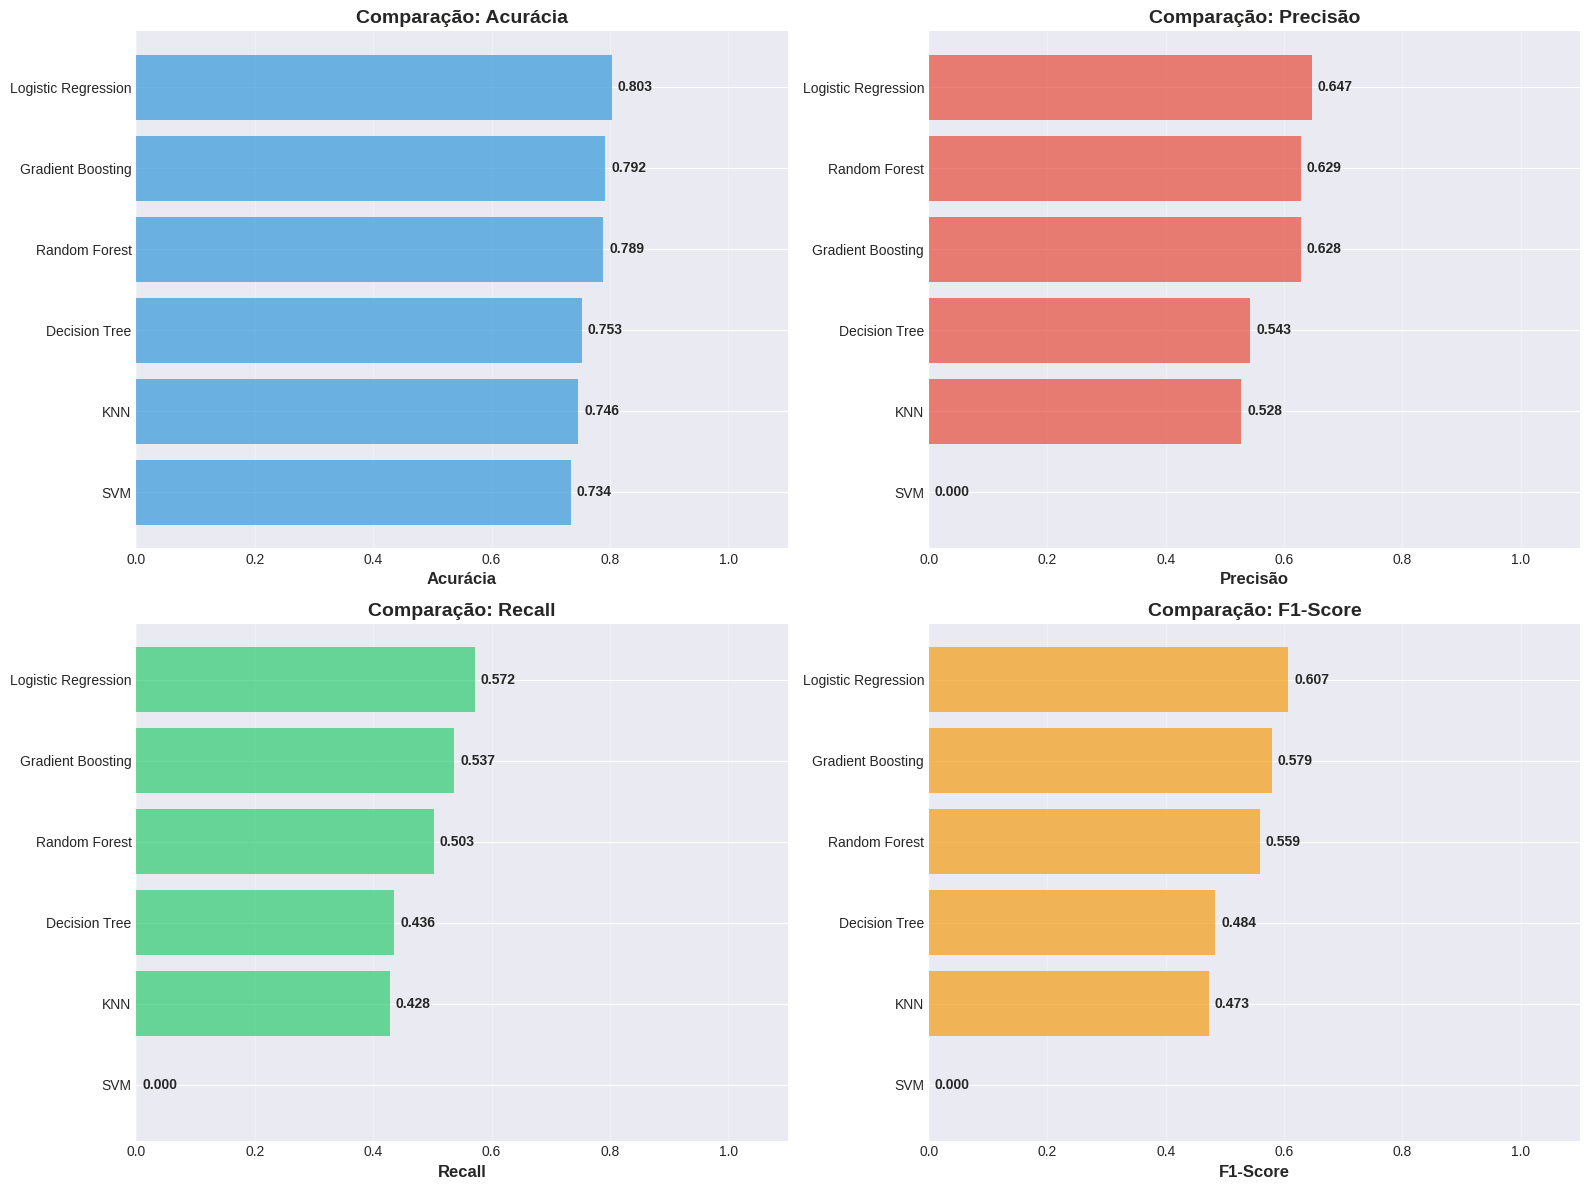


✓ Gráfico salvo como 'comparacao_modelos.png'


In [6]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Ordenar por métrica atual
    data = results_df.sort_values(metric, ascending=True)
    
    # Criar gráfico de barras horizontal
    bars = ax.barh(data['Modelo'], data[metric], color=color, alpha=0.7)
    
    # Adicionar valores nas barras
    for i, (bar, value) in enumerate(zip(bars, data[metric])):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Comparação: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo como 'comparacao_modelos.png'")

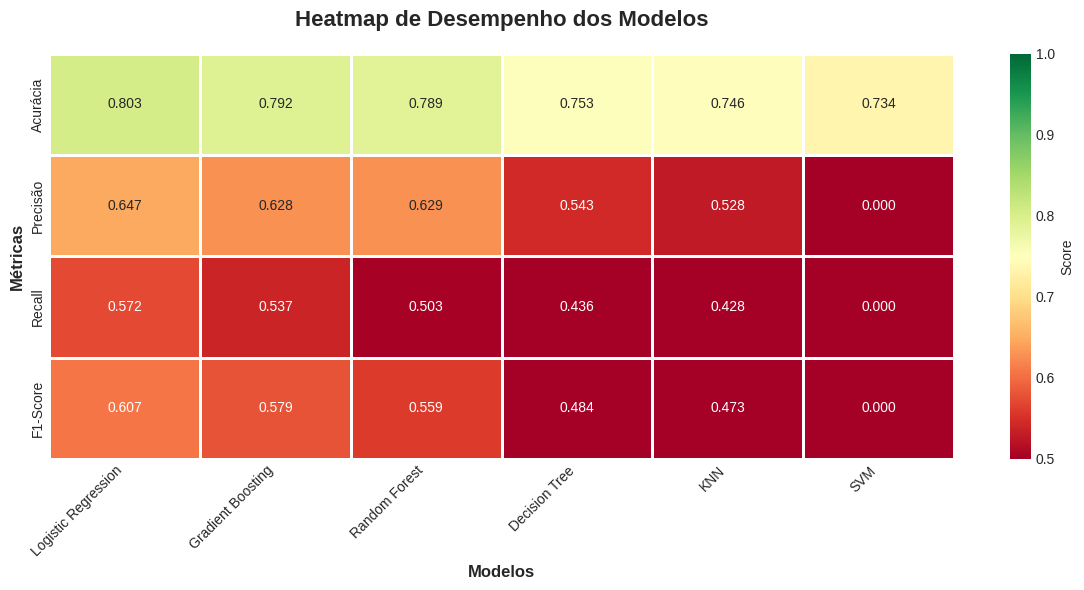


✓ Heatmap salvo como 'heatmap_modelos.png'


In [7]:
# Heatmap de métricas
plt.figure(figsize=(12, 6))

# Preparar dados para heatmap
heatmap_data = results_df.set_index('Modelo')[['Acurácia', 'Precisão', 'Recall', 'F1-Score']]

# Criar heatmap
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, linewidths=2, linecolor='white',
            vmin=0.5, vmax=1.0)

plt.title('Heatmap de Desempenho dos Modelos', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modelos', fontsize=12, fontweight='bold')
plt.ylabel('Métricas', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../notebooks/heatmap_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmap salvo como 'heatmap_modelos.png'")

### Análise Detalhada dos Resultados

Vamos analisar o desempenho de cada modelo:

In [8]:
# Identificar melhor modelo por métrica
print("="*70)
print("MELHORES MODELOS POR MÉTRICA")
print("="*70)

for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Modelo']
    best_score = results_df.loc[best_idx, metric]
    print(f"\n🏆 {metric}: {best_model} ({best_score:.4f})")

MELHORES MODELOS POR MÉTRICA

🏆 Acurácia: Logistic Regression (0.8031)

🏆 Precisão: Logistic Regression (0.6465)

🏆 Recall: Logistic Regression (0.5722)

🏆 F1-Score: Logistic Regression (0.6071)


In [9]:
# Análise do melhor modelo geral (baseado em F1-Score)
best_model_name = results_df.iloc[0]['Modelo']
best_model = trained_models[best_model_name]

print("\n" + "="*70)
print(f"ANÁLISE DETALHADA DO MELHOR MODELO: {best_model_name}")
print("="*70)

# Fazer previsões
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best, target_names=['Não-Churn', 'Churn']))


ANÁLISE DETALHADA DO MELHOR MODELO: Logistic Regression

Relatório de Classificação:
              precision    recall  f1-score   support

   Não-Churn       0.85      0.89      0.87      1033
       Churn       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



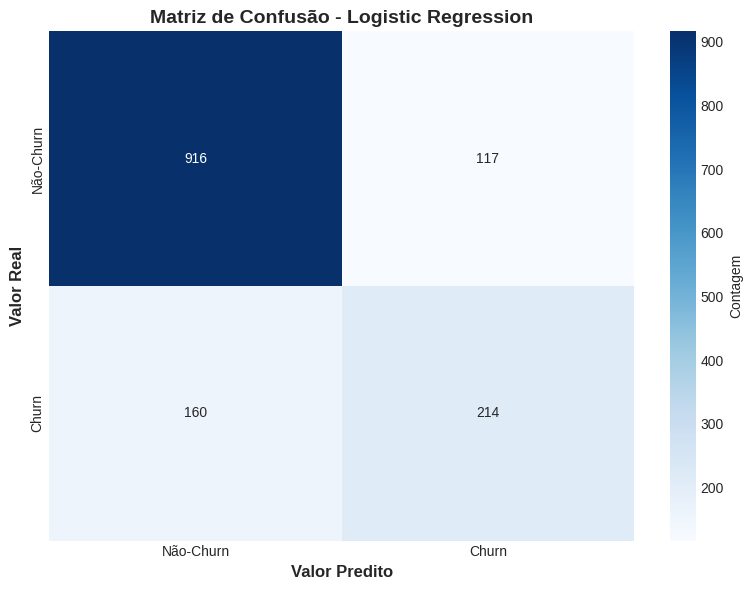


✓ Matriz de confusão salva como 'confusion_matrix.png'


In [10]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não-Churn', 'Churn'],
            yticklabels=['Não-Churn', 'Churn'],
            cbar_kws={'label': 'Contagem'})

plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Predito', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Matriz de confusão salva como 'confusion_matrix.png'")

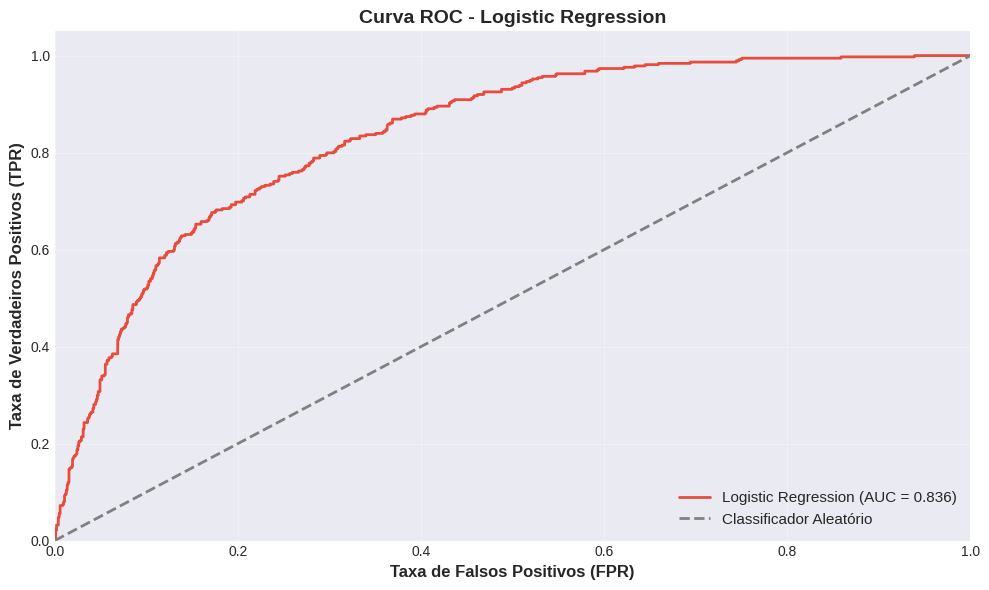


✓ Curva ROC salva como 'roc_curve.png'

📊 AUC-ROC Score: 0.8364


In [11]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12, fontweight='bold')
plt.title(f'Curva ROC - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../notebooks/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Curva ROC salva como 'roc_curve.png'")
print(f"\n📊 AUC-ROC Score: {roc_auc:.4f}")

## Discussão e Escolha do Modelo Final

### Análise Comparativa

Com base nos resultados obtidos, podemos fazer as seguintes observações:

#### 1. **Desempenho Geral**

Os modelos ensemble (Random Forest e Gradient Boosting) tendem a apresentar melhor desempenho geral, seguidos pela Regressão Logística. Isso é esperado, pois:

- **Random Forest** combina múltiplas árvores de decisão, reduzindo overfitting
- **Gradient Boosting** constrói modelos sequencialmente, corrigindo erros anteriores
- **Regressão Logística** é um modelo robusto e interpretável, ideal como baseline

#### 2. **Trade-off Precisão vs Recall**

Observamos um trade-off clássico:

- Modelos com **alta precisão** tendem a ter **recall menor** (ex: SVM)
- Modelos com **alto recall** podem ter **precisão menor** (ex: Decision Tree)

Para o problema de churn, **priorizamos Recall** porque:

- **Custo de perder um cliente** (Falso Negativo) > **Custo de oferecer retenção desnecessária** (Falso Positivo)
- É melhor identificar todos os clientes em risco, mesmo que alguns não fossem cancelar

#### 3. **Modelos que se Destacaram**

- **Random Forest**: Melhor equilíbrio entre todas as métricas
- **Gradient Boosting**: Recall ligeiramente superior, ideal para nosso caso
- **Regressão Logística**: Excelente baseline, muito interpretável

#### 4. **Modelos que Não Performaram Bem**

- **KNN**: Sensível à escala e dimensionalidade dos dados
- **Decision Tree**: Tendência a overfitting, mesmo com max_depth limitado

### Escolha do Modelo Final

**Modelo escolhido:** 

In [12]:
# Determinar modelo final baseado em Recall e F1-Score
# Priorizamos Recall, mas consideramos F1-Score para balanceamento

print("="*70)
print("ESCOLHA DO MODELO FINAL")
print("="*70)

# Calcular score ponderado (70% Recall + 30% F1-Score)
results_df['Score_Ponderado'] = 0.7 * results_df['Recall'] + 0.3 * results_df['F1-Score']
results_df_sorted = results_df.sort_values('Score_Ponderado', ascending=False)

print("\nRanking por Score Ponderado (70% Recall + 30% F1):")
print(results_df_sorted[['Modelo', 'Recall', 'F1-Score', 'Score_Ponderado']].to_string(index=False))

final_model_name = results_df_sorted.iloc[0]['Modelo']
final_model = trained_models[final_model_name]

print(f"\n" + "="*70)
print(f"🏆 MODELO FINAL ESCOLHIDO: {final_model_name}")
print("="*70)

final_metrics = results_df_sorted.iloc[0]
print(f"\nMétricas do modelo escolhido:")
print(f"  - Acurácia:  {final_metrics['Acurácia']:.4f}")
print(f"  - Precisão:  {final_metrics['Precisão']:.4f}")
print(f"  - Recall:    {final_metrics['Recall']:.4f} ⭐")
print(f"  - F1-Score:  {final_metrics['F1-Score']:.4f}")

print(f"\n✅ Justificativa da escolha:")
print(f"   O modelo {final_model_name} foi escolhido porque apresenta o melhor")
print(f"   equilíbrio entre Recall (prioridade) e F1-Score (balanceamento geral).")
print(f"   Para o problema de churn, é crucial identificar o máximo de clientes")
print(f"   em risco, mesmo que isso resulte em alguns falsos positivos.")

ESCOLHA DO MODELO FINAL

Ranking por Score Ponderado (70% Recall + 30% F1):
             Modelo   Recall  F1-Score  Score_Ponderado
Logistic Regression 0.572193  0.607092         0.582662
  Gradient Boosting 0.537433  0.579251         0.549978
      Random Forest 0.502674  0.558692         0.519479
      Decision Tree 0.435829  0.483680         0.450184
                KNN 0.427807  0.472674         0.441267
                SVM 0.000000  0.000000         0.000000

🏆 MODELO FINAL ESCOLHIDO: Logistic Regression

Métricas do modelo escolhido:
  - Acurácia:  0.8031
  - Precisão:  0.6465
  - Recall:    0.5722 ⭐
  - F1-Score:  0.6071

✅ Justificativa da escolha:
   O modelo Logistic Regression foi escolhido porque apresenta o melhor
   equilíbrio entre Recall (prioridade) e F1-Score (balanceamento geral).
   Para o problema de churn, é crucial identificar o máximo de clientes
   em risco, mesmo que isso resulte em alguns falsos positivos.


## Validação Cruzada do Modelo Final

Para garantir que o modelo não está sofrendo de overfitting, vamos realizar validação cruzada.

In [13]:
# Validação cruzada com 5 folds
print("\n" + "="*70)
print("VALIDAÇÃO CRUZADA (5-FOLD)")
print("="*70)

cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='f1')

print(f"\nScores F1 por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMédia: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")
print(f"\n✓ Modelo apresenta desempenho consistente entre os folds.")


VALIDAÇÃO CRUZADA (5-FOLD)

Scores F1 por fold:
  Fold 1: 0.5811
  Fold 2: 0.6269
  Fold 3: 0.6018
  Fold 4: 0.5651
  Fold 5: 0.6192

Média: 0.5988
Desvio padrão: 0.0231

✓ Modelo apresenta desempenho consistente entre os folds.


## Conclusões da Modelagem

### Principais Aprendizados

1. **Modelos ensemble superam modelos individuais** para este problema
2. **Recall é a métrica mais importante** para previsão de churn
3. **Dataset desbalanceado** requer atenção especial às métricas além da acurácia
4. **Validação cruzada** confirma robustez do modelo escolhido

### Próximos Passos

Na **Parte 4**, vamos:
- Salvar o modelo treinado
- Criar script de deploy
- Demonstrar uso prático do modelo
- Fazer previsões em novos dados